### References 
- Code https://github.com/karpathy/pytorch-normalizing-flows
- Code https://github.com/VincentStimper/normalizing-flows
- Lecture: https://deepgenerativemodels.github.io/notes/flow/
- Riemann Manifold with Wasserstein metric https://arxiv.org/pdf/1904.02399.pdf
- Review: https://arxiv.org/pdf/1912.02762.pdf
- Review: https://arxiv.org/pdf/1908.09257v4.pdf
- MAF: https://arxiv.org/pdf/1705.07057.pdf
- MADE: https://arxiv.org/pdf/1502.03509.pdf 
- Neural autoregressive flow (NAF): https://arxiv.org/pdf/1804.00779.pdf
- Block neural autoregressive flow (BNAF): https://arxiv.org/abs/1904.04676
- Time series application: https://arxiv.org/pdf/2002.06103.pdf


### Related: Structure learning:
- Bengio Review: https://arxiv.org/pdf/2111.09266.pdf
- Blog post https://yoshuabengio.org/2022/03/05/generative-flow-networks/
- Tutorial https://milayb.notion.site/GFlowNet-Tutorial-919dcf0a0f0c4e978916a2f509938b00

### Todo:
- Tune optimizer
- Conditional Probs
- Batch Normalization
- dequantization for the example of counts

### Conventions:
Denote the base distribution by $p_U(u)$ and the target distrubution by $p_X(x)$, with a transformation function $f: U \rightarrow X$. 
- $p_X(x) = p_U(f^{-1}(x)) |\text{det}J_{f^{-1}}(x)|$
- Sampling over the target distribution:  $x = f(u), ~~ u\sim p_U(u)$
- Monte Carlo estimate of the Kullback Leibler divergence: Donote the unknown, true distribution by  $p^*_X(x)$
for which samples exist $\{x_1, x_N\} ~\sim p^*_X(x) $

$KL (p^*_X || p_X) \approx \frac{1}{N}\sum_{i=1}^N \ln p_U(f^{-1}(x_i)) + \ln |\det J_{f^{-1}}(x_i)| + \text{const}$

### Example Affine model: 
This is not strictly affine linear but we keep this parametrization in order to assure that $f^{-1}$ exists.
With $x, u, \alpha, \beta \in \mathbb R^d$
- forward $f: u \mapsto e^\alpha u  + \beta $
- forward log Jacobian Determinant: $\ln |\det J_f| = \sum \alpha_i$
- backward $f^{-1}: x \mapsto (x - \beta) e ^{-\alpha}$
- backward log Jacobian Determinant: $\ln |\det J_{f^{-1}}| = - \sum \alpha_i$


### Example RealNVP

### Example MADE


In [1]:
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn
import numpy as np
from torch.distributions import MultivariateNormal
from torch.distributions import Uniform
import torch.optim as optim
from scipy.stats import multivariate_normal


%load_ext autoreload
%autoreload 2

/home/viktor/.local/share/virtualenvs/pytorch_tutorial-3bsPM6__/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Plotting

In [2]:
from matplotlib import pyplot as plt
from matplotlib import rc, rcParams
COLOR="#fd5000"

rc('text', usetex=True)
rcParams.update({'figure.figsize': [16,4],
                 'text.color' : COLOR,
                 'font.size': 10,
                 'axes.labelcolor' : COLOR, 
                 'xtick.color': COLOR, 
                 'ytick.color': COLOR,
                 'legend.framealpha': 0, 
                 'legend.edgecolor': 'none',
                 'font.family': 'Times New Roman'
                 })


def plot(x):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.scatter(x[:,0], x[:,1], s=5, alpha=0.5, color=COLOR)
    ax.set_xlabel("$x_1$", fontsize=16)
    ax.set_ylabel("$x_2$", fontsize=16)

    
def plot_conditionals(distribution, x_cond, y_cond, n, bins=100):
    fig = plt.figure(figsize=(7, 7))
    gs = fig.add_gridspec(2, 2,  
                          width_ratios=(7, 2), 
                          height_ratios=(2, 7),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)
   
    # setup axis
    ax_joint = fig.add_subplot(gs[1, 0])
    ax_xy = fig.add_subplot(gs[0, 0], sharex=ax_joint)
    ax_yx = fig.add_subplot(gs[1, 1], sharey=ax_joint)

    # Plot joint 
    joint = distribution.sample(n)
    ax_joint.scatter(joint[:, 0], joint[:, 1], s=5, alpha=0.5, color=COLOR)
    # x=-1. that is conditioned upon
    ax_joint.set_xlabel('$x_1$', fontsize=16)
    ax_joint.set_ylabel('$x_2$', fontsize=16)
    ax_joint.axvline(x_cond, color="black", ls="--", lw=1)
    ax_joint.axhline(y_cond, color="black", ls="--", lw=1)
    
    # Plot y|x
    pyx = distribution.sample_y_cond_x(x_cond, n)    
    ax_yx.hist(pyx, orientation='horizontal', bins=bins, color=COLOR, label=f'$p(x_2|x_1={x_cond:.1f})$')
    ax_yx.legend()

    # Plot x|y
    pxy = distribution.sample_x_cond_y(y_cond, n)    
    ax_xy.hist(pxy, bins=bins, color=COLOR, label=f'$p(x_1|x_2={y_cond:.1f})$')
    ax_xy.legend()
    
    
def plot_model(model, true_distribution, sample_size=1000):
    model.eval()
    x_true = true_distribution.sample(sample_size)
    x_base = model.base.sample([sample_size])
    x_pred = model.sample(sample_size).detach()
    fig, ax = plt.subplots(figsize=(8,8))
    mu = lambda x: np.round(x.numpy().mean(axis=0), 2)
    std = lambda x: np.round(x.numpy().std(axis=0), 2)
    true_label = f"True $\mu=${mu(x_true)}, $\sigma=$ {std(x_true)}"
    pred_label = f"Pred $\mu=${mu(x_pred)}, $\sigma=$ {std(x_pred)}"
    base_label = f"Base $\mu=${mu(x_base)}, $\sigma=$ {std(x_base)}"
    ax.scatter(x_true[:,0], x_true[:,1], s=20, alpha=0.5, color=COLOR, label=true_label)
    ax.scatter(x_pred[:,0], x_pred[:,1], s=20, alpha=0.5, color="black", label=pred_label)
    ax.scatter(x_base[:,0], x_base[:,1], s=20, alpha=0.1, color="blue", label=base_label)
    ax.set_xlabel("$x_1$", fontsize=16)
    ax.set_ylabel("$x_2$", fontsize=16)
    ax.legend()    
    
def plot_model_conditionals(model, distribution, x_cond, sample_size, bins=100):
    fig = plt.figure(figsize=(10, 5))
    gs = fig.add_gridspec(1, 3,  
                          width_ratios=(7, 2, 2), 
                          #height_ratios=(2, 2, 7),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)
   
    # setup axis
    ax_joint = fig.add_subplot(gs[0, 0])
    ax_true = fig.add_subplot(gs[0, 1], sharey=ax_joint)
    ax_pred = fig.add_subplot(gs[0, 2], sharey=ax_joint)

    # Plot joint 
    joint = distribution.sample(sample_size)
    ax_joint.scatter(joint[:, 0], joint[:, 1], s=5, alpha=0.5, color=COLOR)
    # x=-1. that is conditioned upon
    ax_joint.set_xlabel('$x_1$', fontsize=16)
    ax_joint.set_ylabel('$x_2$', fontsize=16)
    ax_joint.axvline(x_cond, color="black", ls="--", lw=1)
    
    # Plot true y|x
    pyx_true = distribution.sample_y_cond_x(x_cond, sample_size).flatten()    
    ax_true.hist(pyx_true, bins=bins, orientation='horizontal', color=COLOR, label=f'True $p(x_2|x_1={x_cond:.1f})$')
    ax_true.legend()

    # Plot predicted y|x
    pyx_pred = model.sample(x_cond * torch.ones(1,1), sample_size).detach().numpy().flatten()    
    ax_pred.hist(pyx_pred, bins=bins, orientation='horizontal', color=COLOR, label=f'Pred $p(x_2|x_1={x_cond:.1f})$')
    ax_pred.legend()
    
    
# Plot model inference and generation for joint
    
class Points:
    
    def __init__(self, xs):
        self.xs = xs 
        self.min_x = self.get_min_x()
        self.max_x = self.get_max_x()
        self.min_y = self.get_min_y()
        self.max_y = self.get_max_y()
        self.delta_x = self.max_x - self.min_x
        self.delta_y = self.max_y - self.min_y
        
        
    def get_min_x(self):
        return min(self.xs[:, 0])
    
    def get_max_x(self):
        return max(self.xs[:, 0])
    
    def get_min_y(self):
        return min(self.xs[:, 1])
    
    def get_max_y(self):
        return max(self.xs[:, 1])


    

def get_grid_lines(x_range, y_range, pts: int=100):
    
    lines = np.empty((len(x_range)+len(y_range), 2, pts))
    
    for i, value in enumerate(x_range): # vertical lines
        linspace_x = np.linspace(value, value, pts)
        linspace_y = np.linspace(min(y_range), max(y_range), pts)
        lines[i] = (linspace_x, linspace_y)

    for i, value in enumerate(y_range): # horizontal lines
        linspace_x = np.linspace(min(x_range), max(x_range), pts)
        linspace_y = np.linspace(value, value, pts)
        lines[i+len(x_range)] = (linspace_x, linspace_y)
        
    return np.swapaxes(lines, 1, 2).astype(np.float32)


def infer_model(model, xs, flow_mode: str):
    if flow_mode == "forward":
        us, _= model.backward(xs)
    elif flow_mode == "backward":
        us, _= model.forward(xs)
    else:
        raise IOError(f"You speficied unknown flow_mode: {flow_mode}. Valid options 'backward', 'forward'")
    return us.detach().numpy()


def generate_model(model, xs, flow_mode: str):
    if flow_mode == "forward":
        us, _= model.forward(xs)
    elif flow_mode == "backward":
        us, _= model.backward(xs)
    else:
        raise IOError(f"You speficied unknown flow_mode: {flow_mode}. Valid options 'backward', 'forward'")
    return us.detach().numpy()
    

def plot_inference(ax, model, true_distribution, flow_mode="forward", sample_size=500, color=COLOR, title=True):
    # inverence find function f: true distribution -> base distribution
    
    model.eval()
    # data true distribution
    xs = true_distribution.sample(sample_size)
    px = Points(xs)
    # data backward
    us = infer_model(model, xs, flow_mode)
    pu = Points(us)
    
    # make quite a big grid in order to capture transformed space 
    n_grid_lines = 150
    x_range = list(np.linspace(px.min_x - 100, px.max_x + 100, n_grid_lines))
    y_range = list(np.linspace(px.min_y - 100, px.max_y + 100, n_grid_lines))
    grid_lines = get_grid_lines(x_range, y_range, 10000)

    # plot data and grid on true density space
    # data
    ax[1].scatter(xs[:,0], xs[:,1], s=15, alpha=0.3, color=color)
    # grid
    for grid_line in grid_lines:
        ax[1].plot(grid_line[:, 0], grid_line[:, 1], linewidth=0.5, color=color, alpha=.5)
    # optics
    r = 0.2
    ax[1].set_xlim((px.min_x - r * px.delta_x , px.max_x + r * px.delta_x))
    ax[1].set_ylim((px.min_y - r * px.delta_y , px.max_y + r * px.delta_y))
    
    # plot data and grid on back-transformed density space
    #data

    ax[0].scatter(us[:,0], us[:,1], s=15, alpha=0.3, color=color)
    # grid
    for grid_line in grid_lines:
        t = torch.from_numpy(grid_line)
        tgl = infer_model(model, t, flow_mode)
        ax[0].plot(tgl[:, 0], tgl[:, 1], linewidth=0.5, color=color, alpha=.5)
    #optics
    ax[0].set_xlim((pu.min_x - r * pu.delta_x , pu.max_x + r * pu.delta_x))
    ax[0].set_ylim((pu.min_y - r * pu.delta_y , pu.max_y + r * pu.delta_y))
    
    # set titles
    if title:
        ax[0].set_title(r"$\mathcal{U}$", fontsize=20, color=color)    
        ax[1].set_title(r"$\mathcal{X}$", fontsize=20, color=color)        
    
    # additional labels
    if flow_mode == "forward": 
        arrow = r'$\Leftarrow f^{-1}$'
    if flow_mode == "backward": 
        arrow = r'$\Leftarrow f$'
    
    ax[0].text(1.0, .5, arrow,
        fontsize = 20,
        horizontalalignment='left',
        verticalalignment='center',
        color=color,
        transform=ax[0].transAxes)
    
    ax[0].text(-0.1, 0.5, r'Inference',
        fontsize = 20,
        rotation='vertical',
        horizontalalignment='right',
        verticalalignment='center',
        color=color,
        transform=ax[0].transAxes)
    
    for a in ax:
        a.axis("off")
                
        
    
 
def plot_generation(ax, model, true_distribution, flow_mode="forward", sample_size=500, color=COLOR, title=True):
    # generation: given function f and base distribution -> true distribution
    us = model.base.sample((sample_size,))
    pu = Points(us)
    xs = generate_model(model, us, flow_mode) 
    px = Points(xs)
    
    # plot base first on left hand side
    # set up grid lines
    n_grid_lines = 60
    x_range = list(np.linspace(pu.min_x - 15,  pu.max_x + 15, n_grid_lines))
    y_range = list(np.linspace(pu.min_y - 15, pu.max_y + 15, n_grid_lines))
    grid_lines = get_grid_lines(x_range, y_range, 50000)
    # plot data
    ax[0].scatter(us[:,0], us[:,1], s=15, alpha=0.3, color=color)
    # plot grid
    for grid_line in grid_lines:
        ax[0].plot(grid_line[:, 0], grid_line[:, 1], linewidth=0.5, color=color, alpha=.5)
    # optics
    r = 0.2
    ax[0].set_xlim((pu.min_x - r * pu.delta_x , pu.max_x + r * pu.delta_x))
    ax[0].set_ylim((pu.min_y - r * pu.delta_y , pu.max_y + r * pu.delta_y))
    
    # plot data and grid on transformed density space
    # plot data
    ax[1].scatter(xs[:,0], xs[:,1], s=15, alpha=0.3, color=color)
    # plot grid
    for grid_line in grid_lines:
        t = torch.from_numpy(grid_line)
        tgl = generate_model(model, t, flow_mode) 
        ax[1].plot(tgl[:, 0], tgl[:, 1], linewidth=0.5, color=color, alpha=.5)
    #optics
    ax[1].set_xlim((px.min_x - r * px.delta_x , px.max_x + r * px.delta_x))
    ax[1].set_ylim((px.min_y - r * px.delta_y , px.max_y + r * px.delta_y))
    
    # set titles:
    if title:
        ax[0].set_title(r"$\mathcal{U}$", fontsize=20, color=color)  
        ax[1].set_title(r"$\mathcal{X}$", fontsize=20, color=color)
        
    # additional labels
    if flow_mode == "forward": 
        arrow = r"$f \Rightarrow$"
    if flow_mode == "backward": 
        arrow = r"$f^{-1} \Rightarrow$"
    
    ax[0].text(1.0, .5, 
        arrow,
        fontsize = 20,
        horizontalalignment='left',
        verticalalignment='center',
        color=color,
        transform=ax[0].transAxes)
    
    ax[0].text(-0.1, 0.5, r'Generation',
        fontsize = 20,
        rotation='vertical',
        horizontalalignment='right',
        verticalalignment='center',
        color=color,
        transform=ax[0].transAxes)
    
    for a in ax:
        a.axis("off")
    

### Toy Datasets

In [3]:
class DatasetMoons:
    """ Two half-moons """
   
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
        return torch.from_numpy(moons)

    
class DatasetMixture:
    """ 4 mixture of gaussians """
    
    def sample(self, n):
        assert n%4 == 0
        r = np.r_[np.random.randn(n // 4, 2)*0.5 + np.array([0, -2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([0, 0]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([2, 2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([-2, 2])]
        return torch.from_numpy(r.astype(np.float32))

    
class ConditionalGaussians:
    """As in MAF paper, Fig 1. https://arxiv.org/pdf/1705.07057.pdf"""
    
    def sample(self, n): 
        x2 = np.random.normal(0, 2, n)
        x1 = np.random.normal(1 / 4 * x2**2, 1)
        r = np.c_[x1, x2]
        return torch.from_numpy(r.astype(np.float32))
    
    
    
class Gaussian:
    """Simple Gaussian"""
    def sample(self, n):
        x = MultivariateNormal(5*torch.ones(2), 10 * torch.eye(2))
        return x.sample([n])
        

class SuperimposedGaussians:
    """https://peterroelants.github.io/posts/multivariate-normal-primer/"""
    
    def __init__(self):
        self.mu_1 = np.zeros(2)
        self.sigma_1 = np.eye(2) 
        self.mu_2 = np.zeros(2) + 5
        self.sigma_2 = np.eye(2) * 2
        self.mixing = .5
  
    
    def sample(self, n): 
        n1 = int(self.mixing * n)
        n2 = n - n1 
        self.p1 = multivariate_normal(self.mu_1, self.sigma_1)
        self.p2 = multivariate_normal(self.mu_2, self.sigma_2)  
        s1 = self.p1.rvs([n1])
        s2 = self.p2.rvs([n2])
        s = np.concatenate([s1, s2], axis=0) 
        return torch.from_numpy(s.astype(np.float32))
    
    
    
    def marginal_prob_x(self, mu, sigma, x):
        """Single Gaussian"""
        p = multivariate_normal(mu[0], sigma[0, 0])
        return p.pdf(x)
    
    
    def marginal_prob_y(self, mu, sigma, y):
        """Single Gaussian"""
        p = multivariate_normal(mu[1], sigma[1, 1])
        return p.pdf(y)
    
    
    def conditional_params_x_cond_y(self, mu, sigma, y):
        """Single Gaussian"""
        A = sigma[0,0]
        C = sigma[0,1]
        B = sigma[1,1]
        mu_x = mu[0]
        mu_y = mu[1]
        mu_x_cond_y =  mu_x + C / B * (y - mu_y) 
        sigma_x_cond_y = A - C**2 / B 
        return mu_x_cond_y, sigma_x_cond_y
    
    
    def conditional_params_y_cond_x(self, mu, sigma, x):
        """Single Gaussian"""
        A = sigma[0,0]
        C = sigma[0,1]
        B = sigma[1,1]
        mu_x = mu[0]
        mu_y = mu[1]
        mu_y_cond_x = mu_y + C / A  * (x - mu_x)  
        sigma_y_cond_x = B - C / A * C
        return mu_y_cond_x, sigma_y_cond_x
    
        
    
    def sample_x_cond_y(self, y, n, scale_up=True):
        """ Both Gausians.
        Scale up serves to preserve the number of samples
        Actually we would have n1 = a1 * n  and n2 = a2*n which eventually reduces the total number of samples
        if alpha_i is small. 
        
        """
        mu_1, sigma_1 = self.conditional_params_x_cond_y(self.mu_1, self.sigma_1, y)
        mu_2, sigma_2 = self.conditional_params_x_cond_y(self.mu_2, self.sigma_2, y)
        p_1 = multivariate_normal(mu_1, sigma_1)
        p_2 = multivariate_normal(mu_2, sigma_2)
        alpha_1 = self.marginal_prob_y(self.mu_1, self.sigma_1, y)
        alpha_2 = self.marginal_prob_y(self.mu_2, self.sigma_2, y)
        a_1 = self.mixing * alpha_1 / (alpha_1 + alpha_2)
        a_2 = (1- self.mixing) * alpha_2 / (alpha_1 + alpha_2)
        n1 = int(n * a_1)
        n2 = int(n * a_2)
        if scale_up:
            a = a_1 + a_2
            n1 = int(n * a_1 / a)
            n2 = n - n1
               
        #n2 = n - n1 should be true ??
        s1 = p_1.rvs(n1)[:, None]
        s2 = p_2.rvs(n2)[:, None]
        s = np.concatenate([s1, s2], axis=0)
        return s
        #return torch.from_numpy(s.astype(np.float32))
    
    
    def sample_y_cond_x(self, x, n, scale_up=True):
        """Both Gausians.
        Scale up serves to preserve the number of samples
        Actually we would have n1 = a1 * n  and n2 = a2*n which eventually reduces the total number of samples
        if alpha_i is small. 
        
        """
        mu_1, sigma_1 = self.conditional_params_y_cond_x(self.mu_1, self.sigma_1, x)
        mu_2, sigma_2 = self.conditional_params_y_cond_x(self.mu_2, self.sigma_2, x)
        p_1 = multivariate_normal(mu_1, sigma_1)
        p_2 = multivariate_normal(mu_2, sigma_2)
        alpha_1 = self.marginal_prob_x(self.mu_1, self.sigma_1, x)
        alpha_2 = self.marginal_prob_x(self.mu_2, self.sigma_2, x)
        a_1 = self.mixing * alpha_1 / (alpha_1 + alpha_2)
        a_2 = (1- self.mixing) * alpha_2 / (alpha_1 + alpha_2)
        n1 = int(n * a_1)
        n2 = int(n * a_2)
        if scale_up:
            a = a_1 + a_2
            n1 = int(n * a_1 / a)
            n2 = n - n1
               
        #n2 = n - n1 should be true ??
        s1 = p_1.rvs(n1)[:, None]
        s2 = p_2.rvs(n2)[:, None]
        s = np.concatenate([s1, s2], axis=0)
        return s
        #return torch.from_numpy(s.astype(np.float32))

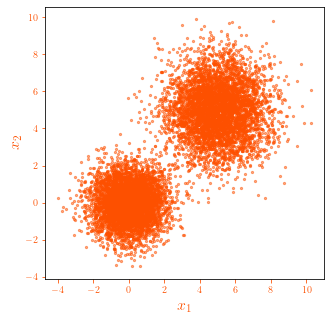

In [4]:
true_distribution = SuperimposedGaussians()
#true_distribution = ConditionalGaussians()
#true_distribution = DatasetMoons()
x = true_distribution.sample(10000)
plot(x)

### Generic Flows

In [5]:
class ComposedFlows(nn.Module): 
    
    def __init__(self, trafos):
        super().__init__()
        self.trafos = nn.ModuleList(trafos)
        
    def forward(self, u): 
        x = u
        # for each element of x the jac det is a scalar so only need batch size
        log_jdet = torch.zeros(u.shape[0]) 
        for trafo in self.trafos: 
            x, ljd = trafo.forward(x)
            log_jdet = log_jdet + ljd
        return x, log_jdet
        
    def backward(self, x):
        u = x
        # for each element of x the jac det is a scalar so only need batch size
        log_jdet_inv = torch.zeros(x.shape[0]) 
        for trafo in self.trafos[::-1]: 
            u, ljd_inv = trafo.backward(u)
            log_jdet_inv = log_jdet_inv + ljd_inv
        return u, log_jdet_inv
    
    
class ForwardNormalizingFlow(nn.Module): 
    """A Normalizing flow is a tuple (base distribution, tranformations)
    This class implements an forward normalizing flow. trafo f: U -> X
    X: Target space
    U: Base Space
    """
    
    def __init__(self, base, trafo):
        super().__init__()
        self.base = base
        self.trafo = trafo
    
    def forward(self, u):
        return self.trafo.forward(u)
    
    def backward(self, x):
        return self.trafo.backward(x)
        
    def log_prob_base(self, u):
        return self.base.log_prob(u)
    
    def sample(self, shape):
        u = self.base.sample((shape,))
        x, _ = self.trafo.forward(u)
        return x 
    
    def kullback_leibler_loss(self, x):
        """Computes the Kullback-Leibler loss w.r.t training data x
        The loss is the negative of the KL divergence. 
        Minimizing this quanitity corresponds to maximizing the KL divergence
        """
        u, log_jdet_inv  = self.backward(x)
        base_logprob = self.log_prob_base(u)
        kl = base_logprob + log_jdet_inv
        return - kl.mean() 
        
    
    
class BackwardNormalizingFlow(nn.Module):
    """A Normalizing flow is a tuple (base distribution, tranformations)
    This class implements a "backward" normalizing flow. trafo f: X -> U
    X: Target space
    U: Base Space
    """
    
    def __init__(self, base, trafo):
        super().__init__()
        self.base = base
        self.trafo = trafo
    
    def forward(self, x):
        return self.trafo.forward(x)
    
    def backward(self, u):
        return self.trafo.backward(u)
    
    def log_prob_base(self, u):
        return self.base.log_prob(u)
    
    def sample(self, shape):
        u = self.base.sample((shape,))
        x, _ = self.backward(u)
        return x
    
    def kullback_leibler_loss(self, x):
        """Computes the Kullback-Leibler loss w.r.t training data x
        The loss is the negative of the KL divergence. 
        Minimizing this quanitity corresponds to maximizing the KL divergence
        """
        u, log_jdet  = self.forward(x)
        base_logprob = self.log_prob_base(u)
        kl = base_logprob + log_jdet
        return - kl.mean()

### Helper Neural Nets

In [6]:
class Mlp(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, out_dim),
        )
        
    def forward(self, x):
        return self.net(x)
        
        
class TensorNN(nn.Module):
    """Net that returns a trainable tensor with shape (1, out_dim). 
    Upon forward pass the input is ignored
    """
    
    def __init__(self, out_dim):
        super().__init__()
        self.out_dim = out_dim
        self.tensor = nn.Parameter(torch.randn(1, self.out_dim, requires_grad=True))
        
    def forward(self, x):
        return self.tensor.expand(x.size(0), self.out_dim)
        

### Linear Models
- Flips and Permutations are not really linear models but it goes in that direction.

In [7]:
from numpy.random import default_rng


class RandomPermutation(nn.Module):
    """A Permutation is just a Flow
    With Jacobi Determinant = 1 (and log Jacobi Determinant = 0)
    """
    
    def __init__(self, dim):
        super().__init__()
        rng = default_rng()
        self.idx = rng.choice(dim, size=dim, replace=False)
         
        
    def forward(self, u):
        return u[:, self.idx], torch.zeros(u.size(0))
    
    def backward(self, x):
        inv_idx = np.argsort(self.idx)
        return x[:, inv_idx], torch.zeros(x.size(0))
    
    def get_permutation(self):
        return self.idx
        
    
    
class Flip(nn.Module):
    """Flip order of indices. This is just a Flow with f = f^-1
    With Jacobi Determinant = 1 (and log Jacobi Determinant = 0)
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, u):
        return torch.flip(u, [1]), torch.zeros(u.size(0))
    
    def backward(self, x):
        return self.forward(x)

### Autoregressive Models

In [8]:

class StaticAffineTransformation(nn.Module):
    
    def __init__(self, scale, shift):
        super().__init__()
        self.scale = scale
        self.shift = shift

    def forward(self, u):
        s = self.scale
        t = self.shift
        x = torch.exp(s) * u + t
        log_jdet = s.sum(axis=1)
        return x, log_jdet
    
    def backward(self, x):
        s = self.scale
        t = self.shift
        u = torch.exp(-s) * (x - t)
        log_jdet_inv = - s.sum(axis=1)
        return u, log_jdet_inv
        
        
class AffineTransformation(nn.Module):
    
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim
        self.s = nn.Parameter(torch.randn(1, dim, requires_grad=True))
        self.t = nn.Parameter(torch.randn(1, dim, requires_grad=True))
        

    def forward(self, u):
        x = torch.exp(self.s) * u + self.t
        log_jdet = self.s.sum(axis=1)
        return x, log_jdet
    
    def backward(self, x):
        u = torch.exp(-self.s) * (x - self.t)
        log_jdet_inv = - self.s.sum(axis=1)
        return u, log_jdet_inv
        

class RealNVP(nn.Module):
    """https://arxiv.org/abs/1605.08803
    Todo: 
        - fix dimensions of neural nets
        in gneral for other than 2 dim, in_dim and out_dim of the net should be different
        in_dim = d =>  out_dim = D-d
    """
    
    def __init__(self, dim, hidden_dim, flip):
        super().__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.flip = flip
        self.mask = self.create_mask()
        self.not_mask = torch.logical_not(self.mask)
        self.s = Mlp(dim, hidden_dim, dim) # get dimensions from mask
        self.t = Mlp(dim, hidden_dim, dim) # get dimensions from mask
        
        
    def create_mask(self):
        mask = torch.zeros(self.dim, dtype=torch.bool)
        mask[::2] = True
        if self.flip:
            return torch.logical_not(mask)
        return mask
        
        
    def forward(self, u):
        x0 = u.masked_fill(self.mask, 0)
        s = self.s(x0)
        t = self.t(x0)
        x1 = torch.exp(s) * u + t  
        x1 = x1.masked_fill(self.not_mask, 0)
        x = x0 + x1
        log_jdet = s.masked_fill(self.not_mask, 0).sum(dim=1) 
        return x, log_jdet
        
        
    def backward(self, x):
        u0 = x.masked_fill(self.mask, 0)
        s = self.s(u0)
        t = self.t(u0)
        u1 = torch.exp(-s) * (x - t)   
        u1 = u1.masked_fill(self.not_mask, 0)
        u = u0 + u1
        log_jdet_inv = - s.masked_fill(self.not_mask, 0).sum(dim=1)
        return u, log_jdet_inv

In [124]:
class SlowConditioner(nn.Module):
    
    def __init__(self, net, dim, hidden_dim, out_dim):
        super().__init__()
        self.net = net
        self.dim = dim
        self.conditioners = nn.ModuleList()
        self.conditioners.append(TensorNN(out_dim))
        for d in range(1, dim):
            self.conditioners.append(self.net(d, hidden_dim, out_dim))
        
    def forward(self, u):
        """Result in tensor of shape (batch, dim, out_dim)
        -> out_dim are the dimensions for the transformer
        """
        h = []
        for d in range(self.dim): 
            conditioner = self.conditioners[d]
            h.append(conditioner(u[:, :d]))
        return torch.stack(h, 1) # stack along dim axis
        
        
class AffineTransformer(nn.Module):
    
    def __init__(self):
        super().__init__()

    def forward(self, u,  h):
        s = h[..., 0] # (batch, dim)
        t = h[..., 1] # (batch, dim)
        x = torch.exp(s) * u + t
        log_jdet = s.sum(axis=1) 
        return x, log_jdet
    
    def backward(self, x, h):
        s = h[..., 0] 
        t = h[..., 1] 
        u = torch.exp(-s) * (x - t)
        log_jdet_inv = - s.sum(axis=1)
        return u, log_jdet_inv
        
        
class GenericAutoregressiveFlow(nn.Module):
    
    def __init__(self, conditioner, transformer, dim):
        super().__init__()
        self.conditioner = conditioner # Recurrent structure
        self.transformer = transformer # Bijection
        self.dim = dim 
        
    def forward(self, u):
        h = self.conditioner(u)
        return self.transformer.forward(u, h) 
    
    def backward(self, x):
        """Iteratively invert - see Equation (40) in https://arxiv.org/pdf/1912.02762.pdf"""
        u = torch.zeros_like(x)
        for d in range(self.dim): 
            h = self.conditioner(u)
            u, log_jdet_inv = self.transformer.backward(x, h)
        return u, log_jdet_inv

In [120]:
### MADE


class MaskedLinear(nn.Linear):
    
    def __init__(self, in_features, out_features, mask, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', mask)
        #print(f"in dim {in_features} out dim {out_features} weight shape {self.weight.shape} mask {mask.shape}")
    
    def forward(self, xs):
        return nn.functional.linear(xs, self.weight * self.mask, self.bias)
    
        
def as_tensor_list(xs : list):
    return [torch.from_numpy(x.astype(np.uint8)) for x in  xs]

class MaskGenerator:
    """Generate masks. Note that the output masks has the form (transfomer_dim * dim)
    So for a given dim all the transfomer dims are grouped together and then for the next dim and so on
    """
    
    def __init__(self, 
                 dim: int, 
                 hidden_dims: list, 
                 expand_output: int, 
                 permute_input: bool = False): 
        self.dim = dim
        self.hidden_dims = hidden_dims
        self.expand_output = expand_output
        self.permute_input = permute_input
        
    def dimension_cutoffs_per_neuron(self): 
        # Better call this connectivity
        rng = np.random.RandomState()
        input_m = rng.permutation(self.dim) if self.permute_input else np.arange(self.dim)
        ms = [input_m]
        for i, hidden_dim in enumerate(self.hidden_dims): 
            hidden_m = rng.randint(ms[i].min(), self.dim - 1, size=hidden_dim)
            ms.append(hidden_m)
        output_m = np.repeat(input_m, self.expand_output)
        ms.append(output_m)
        return ms
    
    
    def get_masks(self):
        ms = self.dimension_cutoffs_per_neuron()
        masks = [] 
        for out_m, in_m  in zip(ms[1:], ms):
            masks.append(out_m[:, None] >= in_m[None, :])
        # last mask need a true gt 
        masks[-1] = ms[-1][:, None] > ms[-2][None, :]
        return as_tensor_list(masks)
        
        
class MaskedConditioner(nn.Module):
    """Conditioner from MADE paper: https://arxiv.org/pdf/1502.03509.pdf
    Todo need to reshape output in the form (batch, dim, h)
    """
    
    def __init__(self,  
                 dim: int, 
                 hidden_dims: list, 
                 expand_output: int, 
                 permute_input: bool = False):
        super().__init__()
        self.dim = dim
        self.expand_output = expand_output
        mg = MaskGenerator(dim, hidden_dims, expand_output, permute_input)
        masks = mg.get_masks()
        dims = [dim] + hidden_dims + [dim * expand_output]
        self.net = self.setup_net(dims, masks)

        
    def setup_net(self, dims, masks):
        assert len(masks) == len(dims) - 1, "Masks dont fit!"
        net = []
        for dim_in, dim_out, mask in zip(dims, dims[1:], masks):
            net.append(MaskedLinear(dim_in, dim_out, mask))
            net.append(nn.ReLU())
        net.pop() # remove last relu
        return nn.Sequential(*net)

    def forward(self, u):
        """Applies net and returns result in the shape (batch, dim, out_dim). 
        This is compatible with np.repeat from last layer masks"""
        result = self.net(u)
        return result.view(u.size(0), self.dim, self.expand_output)

In [158]:
# NAF

from pynverse import inversefunc


class Softmax(nn.Module):

    def __init__(self, dim):
        super().__init__()
        self.softmax = nn.Softmax(dim=dim)
        self.log_softmax = nn.LogSoftmax(dim=dim) 
        
    def forward(self, x):
        return self.softmax(x)
    
    def log(self, x):
        return self.log_softmax(x)
        
    
    
class Logit(nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return torch.logit(x)
        
    def log_deriv(self, x):
        return - torch.log(x) - torch.log(1 - x)
        
        
class Softplus(nn.Module):
    
    def __init__(self, epsilon):
        super().__init__()
        self.epsilon = epsilon
        self.softplus = nn.Softplus()
    
    def forward(self, x):
        return self.softplus(x) + self.epsilon
    
    def log(self, x):
        # log of log -> thats why we use an epsilon
        return torch.log(self.forward(x))
    
        
class Sigmoid(nn.Module):
    """Compute adapted sigmoid function induced by adapted softplus function
    The softplus function is used in the log_deriv. The sigmoid needs to be compatible with this.
    """
    
    def __init__(self, epsilon):
        super().__init__()
        self.sigmoid = nn.Sigmoid()
        self.epsilon =  torch.FloatTensor([epsilon])
        self.softplus = Softplus(epsilon)
        
    def forward(self, x):
        return self.sigmoid(x) * (1 - self.epsilon)
    
    def log_deriv(self, x):
        return (-self.softplus(-x) 
                - self.softplus(-x) 
                + 2 * self.epsilon 
                + torch.log(1 - self.epsilon))

        

class DeepSigmoidFlow(nn.Module):
    """
    Reference Paper: https://arxiv.org/pdf/1804.00779.pdf
    Reference Implementation: https://github.com/CW-Huang/torchkit/blob/7a873f0bb6e0a683cf4b6b5835ceabf2c861e882/torchkit/flows.py#L281
    Replaces Affine Flow. Let's start with one Layer but should generalize to multiple layers"""
    
    def __init__(self, h_dim,  epsilon=1e-6):
        super().__init__()
        self.h_dim = h_dim
        self.epsilon = epsilon
        self.softplus = Softplus(epsilon)
        self.softmax = Softmax(dim=2) # normalize along h-axis
        self.sigmoid = Sigmoid(epsilon) 
        self.logit = Logit()
    
    def forward(self, x, params):
        """https://arxiv.org/pdf/1804.00779.pdf Appendix C.2.1
        Denote the dimension of the distribution by d and the number of hidden units in the Network layer by h
        Then we expect the following input dimensions:
        
        Input dimensions:
        dim x = (batch, d)
        dim a = (batch, d, h)
        dim b = (batch, d, h)
        dim w = (batch, d, h)
        
        Output dimension:
        dim y = (batch, d)
        """
        
        # transform input
        a_, b, w_ = self.extract_from_params(params)
        # enforce constraints weights in order to assure strict monotonicity
        a = self.softplus(a_)
        w = self.softmax(w_) 
        y_pre_sigmoid = a * x[..., None] + b
        y_pre_logit = self.sigmoid(y_pre_sigmoid)
        y_pre_logit = torch.sum(w * y_pre_logit, dim=2) 
        # epsilon/2 could go into the sigmoid, which would not change the derivative
        # however it is used in the reference calculation as constant after matrix multiplication with w
        # we stick to the reference implementation
        y_pre_logit = y_pre_logit + self.epsilon / 2
        y = self.logit(y_pre_logit)
        
        # log jac determinant 
        # (diagonal elements are enough as we have triangular jacobians by construction)
        log_a = self.softplus.log(a_) #dim (batch, h, d)
        log_w = self.softmax.log(w_) # dim (batch, h, d)
        log_logit_deriv = self.logit.log_deriv(y_pre_logit) # dim (batch, d)
        log_sigmoid_deriv = self.sigmoid.log_deriv(y_pre_sigmoid) #dim (batch, h, d)
        
        # dim log_jac = (batch, d)
        log_jac = (log_logit_deriv + 
                   # product + contraction along h in numerical stable way using logsumexp
                   torch.logsumexp(log_w + log_sigmoid_deriv + log_a, dim=2))
                   
        # sum along d-axis -> dim log_jac_det = (batch)
        log_jac_det = log_jac.sum(dim=1)
                   
        return y, log_jac_det
            
    def extract_from_params(self, params):
        assert params.shape[-1] == self.h_dim * 3, f"Require 3 x {h_dim} dimensions along last axis"
        a = params[..., 0 * self.h_dim : 1*self.h_dim]
        b = params[..., 1 * self.h_dim : 2*self.h_dim] 
        w = params[..., 2 * self.h_dim : 3*self.h_dim] 
        return a, b, w
                   
                   
    def backward(self, y, params):
        """Backward transformation needs to be done numerically via root finding"""
        print(f"Inverse function y {y.shape} params {params.shape}")
        f = lambda x: self.forward(x, params)[0]
        # inv does not work with slicing - still raises an error
        f_inv = inversefunc(f)
        # todo return inv jac det from forward jac det
        return f_inv(y)
    


In [160]:
class SlowMAF(GenericAutoregressiveFlow):
    
    def __init__(self, dim):
        conditioner = SlowConditioner(net=Mlp, dim=dim, hidden_dim=32, out_dim=2)
        transformer = AffineTransformer()
        super().__init__(conditioner, transformer, dim)
        
class MAF(GenericAutoregressiveFlow):
    
    def __init__(self, dim, permute_input):
        conditioner = MaskedConditioner(dim, [32]*2, 2, permute_input)
        transformer = AffineTransformer()
        super().__init__(conditioner, transformer, dim)
        
class SlowNAF(GenericAutoregressiveFlow):
    # Todo: compare to reference implementation 
    
    def __init__(self, dim, transformer_dim):
        conditioner = SlowConditioner(net=Mlp, dim=dim, hidden_dim=32, out_dim=3*transformer_dim)
        transformer = DeepSigmoidFlow(transformer_dim)
        super().__init__(conditioner, transformer, dim)
    

### Stack transformations
- just flipping seems to wrong for autregressive methods. 
- this can be seen as convergence gets much worse for flip order change: i+1 % 2 -> i % 2

In [117]:
FLOWMODE = "backward"

base = MultivariateNormal(torch.zeros(2), torch.eye(2))

#trafos = ComposedFlows([RealNVP(dim=2, hidden_dim=24, flip=bool(i%2)) for i in range(4)])

trafos = []
for i in range(1):
    #trafos.append(RandomPermutation(dim=2))
    #trafos.append(SlowMAF(dim=2))
    #trafos.append(MAF(dim=2, permute_input=bool(i%2)))
    #trafos.append(MAF(dim=2, permute_input=False))
    #trafos.append(RealNVP(dim=2, hidden_dim=24, flip=bool(i%2)))
    trafos.append(SlowNAF(dim=2, transformer_dim=16))
    #trafos.append(SlowNAFReference(dim=2, transformer_dim=16))
    
    
    
trafos = ComposedFlows(trafos)    


In [118]:
def get_model(base, trafos, flowmode):
    if flowmode == "forward":
        return ForwardNormalizingFlow(base, trafos)
    if flowmode == "backward":
        return BackwardNormalizingFlow(base, trafos)
    
    
def trainer(true_distribution, model: ForwardNormalizingFlow, optimizer, n_steps=10000):
    """Train normalizing flows forward"""
    for k in range(n_steps):
        x = true_distribution.sample(128)
        loss = model.kullback_leibler_loss(x)
        model.zero_grad()
        loss.backward()
        optimizer.step()

        if k % (n_steps//10) == 0:
            print(loss.item())
       
            
torch.autograd.set_detect_anomaly(False)    
model = get_model(base, trafos, FLOWMODE)
print("number of params: ", sum(p.numel() for p in model.parameters()))
model.train()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) # todo tune WD
trainer(true_distribution, model, optimizer=optimizer, n_steps=10000)

number of params:  3808
3.8807694911956787
-1.1567643880844116
-2.9222981929779053
-4.055570125579834
-4.769085884094238
-5.416233539581299
-6.128293514251709
-6.438048362731934
-6.649867057800293
-7.167306423187256


In [178]:
model.eval()

conditioner = model.trafo.trafos[0].conditioner
transformer = model.trafo.trafos[0].transformer
ys = model.base.sample((10,))
hs = conditioner(ys)
transformer(xs, hs)

ys_numpy = ys.detach().numpy()
f = lambda k: ys - transformer(k, hs)[0].detach().numpy()

from scipy import optimize

inv = optimize.root(f, ys_numpy, method='broyden1', tol=1e-14)


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [174]:
f = lambda x: xs[:, 1] - 3*x
print(f(xs[:, 1]))
from scipy import optimize
inv = optimize.root(f, xs[:, 1], method='broyden1', tol=1e-14)
print(f"true roots \n {xs[:, 1] / 3}")
print(inv)

tensor([ 3.6367,  1.8385, -1.4644,  1.0338, -1.0661, -0.1482, -1.2553,  2.7414,
        -0.0335,  0.4899])
true roots 
 tensor([-0.6061, -0.3064,  0.2441, -0.1723,  0.1777,  0.0247,  0.2092, -0.4569,
         0.0056, -0.0816])
     fun: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)
 message: 'A solution was found at the specified tolerance.'
     nit: 4
  status: 1
 success: True
       x: array([-0.6061136 , -0.30642307,  0.24407244, -0.1723061 ,  0.1776875 ,
        0.0246957 ,  0.20921062, -0.45690635,  0.00558305, -0.08164749],
      dtype=float32)


In [113]:
# plot result
model.eval()

# first glance
plot_model(model, true_distribution)
     
# plot_generation and inference        
color = "black"     
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
plot_generation(ax[0,:], model, true_distribution, flow_mode=FLOWMODE, sample_size=1000, color=color, title=True)
plot_inference(ax[1,:], model, true_distribution, flow_mode=FLOWMODE, sample_size=1000, color=color, title=False)

plt.subplots_adjust(wspace=None)
fig.patch.set_alpha(0.0) # transparent background
#fig.savefig("flow_illustration_yellow." + "svg", format="svg",  bbox_inches=0, tranparent=True)
#fig.savefig("flow_illustration_black." + "pdf", format="pdf",  bbox_inches=0, tranparent=True)

Inverse function y torch.Size([1000, 2]) params torch.Size([1000, 2, 48])


TypeError: 'float' object is not subscriptable

### Supervised learning problem

In [55]:
class ComposedSupervisedFlows(nn.Module): 
    
    def __init__(self, trafos):
        super().__init__()
        self.trafos = nn.ModuleList(trafos)
        
    def forward(self, y, u): 
        """y: conditioning variables
           u: variables to transform
        """
        x = u
        # for each element of x the jac det is a scalar so only need batch size
        log_jdet = torch.zeros(u.shape[0]) 
        for trafo in self.trafos: 
            x, ljd = trafo.forward(y, x)
            log_jdet = log_jdet + ljd
        return x, log_jdet
        
    def backward(self, y, x):
        """y: conditioning variables
           x: variables to back transform
        """
        u = x
        # for each element of x the jac det is a scalar so only need batch size
        log_jdet_inv = torch.zeros(x.shape[0]) 
        for trafo in self.trafos[::-1]: 
            u, ljd_inv = trafo.backward(y, u)
            log_jdet_inv = log_jdet_inv + ljd_inv
        return u, log_jdet_inv
    
    
    
class BackwardNormalizingSupervisedFlow(nn.Module):
    """A Normalizing flow is a tuple (base distribution, tranformations)
    This class implements a "backward" normalizing flow. trafo f: X -> U
    X: Target space
    U: Base Space
    """
    
    def __init__(self, base, trafo):
        super().__init__()
        self.base = base
        self.trafo = trafo
    
    def forward(self, y, x):
        return self.trafo.forward(y, x)
    
    def backward(self, y, u):
        return self.trafo.backward(y, u)
    
    def log_prob_base(self, u):
        return self.base.log_prob(u)
    
    def sample(self, y, n_samples):
        """
        Dimension y: (n_data_points, in_dim)
        Dimension output: (n_data_points, n_samples, out_dim)
        """
        n_data_points = y.size(0)
        u = self.base.sample((n_samples * n_data_points, )) # (n_samples * data_points, out_dim) 
        y_ext = y.repeat(n_samples, 1)
        x, _ = self.backward(y_ext, u) #(n_samples * data_points, out_dim)
        # reshape
        x = x.view(n_samples, n_data_points, x.size(1))
        return torch.swapaxes(x, 0,1)
    
    def kullback_leibler_loss(self, y, x):
        """Computes the Kullback-Leibler loss w.r.t training data x
        The loss is the negative of the KL divergence. 
        Minimizing this quanitity corresponds to maximizing the KL divergence
        """
        u, log_jdet  = self.forward(y, x)
        base_logprob = self.log_prob_base(u)
        kl = base_logprob + log_jdet
        return - kl.mean()


class GenericAutoregressiveSupervisedFlow(nn.Module):
    
    def __init__(self, conditioner, transformer, dim):
        super().__init__()
        self.conditioner = conditioner # Recurrent structure
        self.transformer = transformer # Bijection
        self.dim = dim 
        
    def forward(self, y, u):
        h = self.conditioner(y, u)
        return self.transformer.forward(u, h) 
    
    def backward(self, y, x):
        """Iteratively invert - see Equation (40) in https://arxiv.org/pdf/1912.02762.pdf"""
        u = torch.zeros_like(x)
        for d in range(self.dim): 
            h = self.conditioner(y, u)
            u, log_jdet_inv = self.transformer.backward(x, h)
        return u, log_jdet_inv
    

class SlowSupervisedConditioner(nn.Module):
    
    def __init__(self, net, dim, cond_dim, hidden_dim, out_dim):
        super().__init__()
        self.net = net
        self.dim = dim
        self.cond_dim = cond_dim # conditional set
        self.conditioners = nn.ModuleList()
        self.conditioners.append(TensorNN(out_dim))
        for d in range(1, dim):
            self.conditioners.append(self.net(self.cond_dim + d, hidden_dim, out_dim))
        
    def forward(self, y, u):
        """Result in tensor of shape (batch, dim, out_dim)
        -> out_dim are the dimensions for the transformer
        """
        h = []
        for d in range(self.dim): 
            conditioner = self.conditioners[d]
            y_and_u = torch.cat([y, u[:, :d]], axis=1)
            h.append(conditioner(y_and_u))
        return torch.stack(h, 1) # stack along dim axis

    
class SlowSupervisedMAF(GenericAutoregressiveSupervisedFlow):
    
    def __init__(self, dim, cond_dim):
        conditioner = SlowSupervisedConditioner(net=Mlp, dim=dim, cond_dim=cond_dim, hidden_dim=32, out_dim=2)
        transformer = AffineTransformer()
        super().__init__(conditioner, transformer, dim)
        
        
        
class AffineSupervisedTransformation(nn.Module):
    
    def __init__(self,  dim, cond_dim, net=Mlp):
        super().__init__()
        self.dim = dim
        self.net = net(cond_dim, 32, dim * 2)
        
    def forward(self, y, u):
        hs = self.net(y)
        s, t = self.affine_params(hs)
        x = torch.exp(s) * u + t
        log_jdet = s.sum(axis=1)
        return x, log_jdet
    
    def backward(self, y, x):
        hs = self.net(y)
        s, t = self.affine_params(hs)
        u = torch.exp(-s) * (x - t)
        log_jdet_inv = - s.sum(axis=1)
        return u, log_jdet_inv
    
    def affine_params(self, hs):
        st = hs.view(hs.size(0), self.dim, 2)
        return st[..., 0], st[..., 1] 

### Invert function

In [18]:
from pynverse import inversefunc


def invert(f, y):
    """Returns f⁻1(y)"""
    f_inv = inversefunc(f)
    return f_inv(y)



f = lambda x: x**3
ys = torch.randn(10, 2)

xs = invert(f, ys)
print(xs)

[[-0.63088307  1.22621384]
 [-0.72622092 -0.76558439]
 [ 1.11560079 -0.67888412]
 [ 0.79686902  0.8387673 ]
 [ 0.76974062  1.20198212]
 [-0.91186606  0.62818352]
 [ 1.0792431   1.01765381]
 [ 0.88207922 -1.12135011]
 [ 0.20289793  1.00881492]
 [-0.72317238 -1.02905982]]


'    \nclass SigmoidFlowCopy(BaseFlow):\n    \n    def __init__(self, num_ds_dim=4):\n        super(SigmoidFlow, self).__init__()\n        self.num_ds_dim = num_ds_dim\n        \n        self.act_a = lambda x: nn_.softplus(x)\n        self.act_b = lambda x: x\n        self.act_w = lambda x: nn_.softmax(x,dim=2)\n        \n    def forward(self, x, logdet, dsparams, mollify=0.0, delta=nn_.delta):\n        \n        ndim = self.num_ds_dim\n        a_ = self.act_a(dsparams[:,:,0*ndim:1*ndim])\n        b_ = self.act_b(dsparams[:,:,1*ndim:2*ndim])\n        w = self.act_w(dsparams[:,:,2*ndim:3*ndim])\n        \n        a = a_ * (1-mollify) + 1.0 * mollify\n        b = b_ * (1-mollify) + 0.0 * mollify\n        \n        pre_sigm = a * x[:,:,None] + b\n        sigm = torch.sigmoid(pre_sigm)\n        x_pre = torch.sum(w*sigm, dim=2)\n        x_pre_clipped = x_pre * (1-delta) + delta * 0.5 # delta =  1e-6 constant\n        x_ = log(x_pre_clipped) - log(1-x_pre_clipped) # = logit\n        xnew = x

In [2]:
import torch

/home/viktor/.local/share/virtualenvs/pytorch_tutorial-3bsPM6__/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
sm = nn.Softmax(dim=1)
tsm = sm(t)
tsm.shape

torch.Size([16, 10, 2])

In [48]:
def supervised_trainer(true_distribution, model: BackwardNormalizingSupervisedFlow, optimizer, n_steps=10000):
    """Train normalizing flows forward"""
    for k in range(n_steps):
        samples = true_distribution.sample(128)
        cond = samples[:, 0, None] # conditioning set
        target = samples[:, 1, None] # train distribution on x
        loss = model.kullback_leibler_loss(cond, target)
        model.zero_grad()
        loss.backward()
        optimizer.step()

        if k % (n_steps//10) == 0:
            print(loss.item())

In [50]:
base = MultivariateNormal(torch.zeros(1) - 2, 0.1 * torch.eye(1))
trafos = []
for i in range(2):
    #trafos_supervised.append(RandomPermutation(dim=1))
    #trafos.append(SlowSupervisedMAF(dim=1, cond_dim=1))    
    trafos.append(AffineSupervisedTransformation(dim=1, cond_dim=1))    
    
trafos = ComposedSupervisedFlows(trafos)    
model = BackwardNormalizingSupervisedFlow(base, trafos)
print("number of params: ", sum(p.numel() for p in model.parameters()))
model.train()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) # todo tune WD
supervised_trainer(true_distribution, model, optimizer=optimizer, n_steps=10000)

number of params:  4484
166.2203369140625
2.567448377609253
1.9116276502609253
1.640454888343811
1.75814688205719
1.645000696182251
1.681217908859253
1.6315973997116089
1.6193573474884033
1.6915658712387085


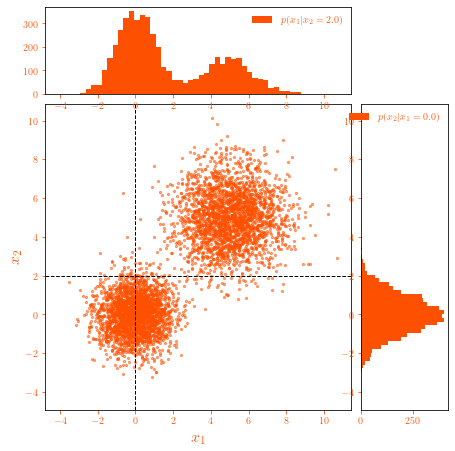

In [51]:
plot_conditionals(true_distribution, 0, 2, 5000, bins=50)

Shape y_ext: torch.Size([5000, 1]), u: torch.Size([5000, 1])


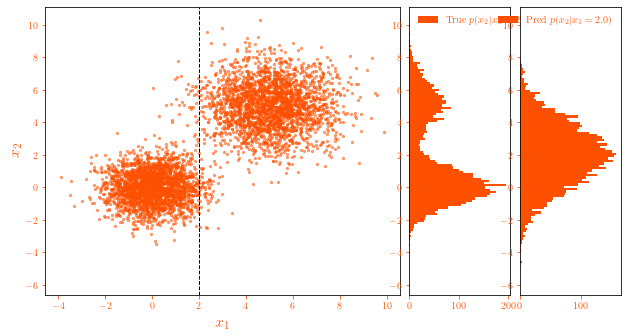

In [70]:
model.eval();

plot_model_conditionals(model, true_distribution, 2, 5000)

Shape y_ext: torch.Size([1000, 1]), u: torch.Size([1000, 1])


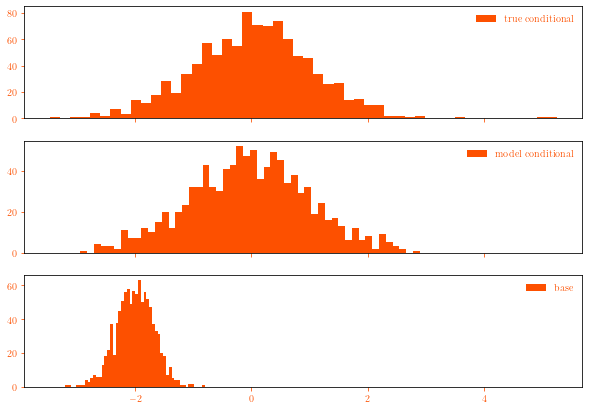

In [54]:
n_samples = 1000
bins=50
base_samples = base.sample((n_samples,)).numpy().flatten()
model_samples = model.sample(torch.zeros(1,1), n_samples).detach().numpy().flatten()
true_samples = true_distribution.sample_y_cond_x(0, n_samples).flatten()
fig, ax = plt.subplots(3, figsize=(10,7), sharex=True)
ax[0].hist(true_samples, bins=bins, color=COLOR, label="true conditional")
ax[1].hist(model_samples, bins=bins, color=COLOR, label="model conditional")
ax[2].hist(base_samples, bins=bins, color=COLOR, label="base")
for a in ax:
    a.legend()

###  Reimplementation
- use Bijection base class
- maybe also implement inverse process

In [ ]:
# todo implement a bijector class from which each transformation inherts
# this should only implemtent the backward_log_jacobian
# https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/Bijector

class Bijection(nn.Module):
    """A bijection is a function f: x -> y"""
    
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        raise NotImplementedError

    def log_det_jacobian(self, x):
        raise NotImplementedError    
        
    def backward(self, y):
        raise NotImplementedError
            
    def log_det_inverse_jacobian(self, y):
        return - self.log_det_jacobian(self.inverse(y))